# Plot BlueSeis BSPF Events from Catalog

! Should be run in pygmt environment !

With pressure sensor parascientific and new sensor 

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
coords = pd.read_csv("NamesCoordinates_2005.txt", delimiter=" ", names=["stationname","latitude","longitude","pos"])

## Configurations

In [4]:
config = {}

config['BSPF_lon'] = -122.1911
config['BSPF_lat'] = 46.1994

config['minlatitude'] = coords.latitude.min() - 0.05
config['maxlatitude'] = coords.latitude.max() + 0.05
config['minlongitude'] = coords.longitude.min() - 0.1
config['maxlongitude'] = coords.longitude.max() + 0.1


# config['tbeg'] = obs.UTCDateTime("2022-10-01")
# config['tend'] = obs.UTCDateTime("2023-03-31")

# config['eventfile'] = "BSPF_event_catalog_extended"
# config['triggerfile'] = "trigger_all.pkl"

# config['path_trigger'] = data_path+"/BSPF/trigger3/"
# config['path_catalog'] = data_path+"/BSPF/data/"
# config['out_figures'] = data_path+"/BSPF/figures/"

# config['outpath'] = data_path+"/BSPF/"

In [29]:
coords['offsets'] = np.zeros(len(coords))-0.3

In [50]:
def __makeplot_eventmap(config, data):


    import pygmt
    import pandas as pd


    # Set the region
    region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

    proj = 'M5i'

    resolution = "03s"

    fig = pygmt.Figure()


    ## make color pallets
    cmap_topo = pygmt.makecpt(cmap='geo', series='0/8000/1000', continuous=True)

    ## define etopo data file
    topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)


    # fig.basemap(region=region, projection=proj)

    ## adjust land and sea/lakes
    land = topo_data * pygmt.grdlandmask(region=region,
                                         spacing=resolution,
                                         maskvalues=[0, 1],
                                         resolution="f"
                                        )


    ##plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection=proj,
        shading=True,
        cmap = cmap_topo,
        frame=True,
        nan_transparent=True
    )

    wet = topo_data * pygmt.grdlandmask(region=region,
                                        spacing=resolution,
                                        maskvalues=[1, "NaN"],
                                        resolution="f"
                                       )

#     cmap_wet = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

#     fig.grdimage(
#         grid=wet,
#         region=region,
#         projection=proj,
#         shading=True,
#         cmap='seafloor',
#         frame=True,
#         nan_transparent=True
#     )


    cmap_topo = pygmt.makecpt(cmap='geo', series='0/4000/1000', truncate="0/4000", continuous=True)
    fig.colorbar(cmap=cmap_topo, position=f"g-122.42/46.26+w3c/0.3c", box="+gwhite+c0.1+r",
                 frame=["x+lElevation", r"y+l(km)"], scale=0.001, transparency=20)


    ## add coastlines
    fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)

    ## add scale
    # fig.basemap(map_scale="jBL+c46+f+w5k+u+o10.9/.6",frame=False)


    fig.plot(
        x=data.longitude,
        y=data.latitude,
        style="c0.3c",
        pen="1.5p,blue",
    )



    ## plot
    fig.plot(
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        size=np.array([0.3]),
        fill="red",
        style="t0.5c",
        pen="black",
    )

    for ttt, lat, lon, off, pos in zip(data.stationname, data.latitude, data.longitude, data.offsets, data.pos): 
        if ttt == "MSH-526":
            off = "-0.4/-0.2"
        if ttt == "MSH-512":
            off = "0.1/-0.2"
        if ttt == "MSH-522":
            off = "0.1/-0.2"
        if ttt == "MSH-506":
            off = "0.1/-0.2"
        if ttt == "MSH-535":
            off = "-0.3/-0.2"
        if ttt in ["MSH-503", "MSH-513", "MSH-514"]:
            off = "-0./-0.3"
        if ttt in ["MSH-506", "MSH-512", "MSH-522"]:
            off = "0.2/-0.3"

        if ttt in ["MSH-507", "MSH-536"]:
            continue

        fig.text(
                text=ttt[4:],
                x=lon,
                y=lat,
                offset=off,
                font="9p,Helvetica-Bold,black",
                justify=pos
        )

    for stn, lon, lat, off, pos in zip(data.stationname, data.longitude, data.latitude, data.offsets, data.pos):
        if stn in ["MSH-507", "MSH-536"]:
            fig.plot(
                x=lon,
                y=lat,
                style="c0.3c",
                pen="1.5p,white",
            )

            if stn == "MSH-512":
                off = "0.1/-0.2"
            if stn == "MSH-536":
                off = "-0.2/0.3"

            fig.text(
                    text=stn[4:],
                    x=lon,
                    y=lat,
                    offset=off,
                    font="9p,Helvetica-Bold,black",
                    justify=pos,
                    fill="white"
            )

#     ## add depth colorbar
#     fig.colorbar(frame='af+l"Depth (km)"', cmap=cmap_depth)
#     fig.colorbar(frame='af+l"Days"', transparency=20, cmap=cmap_mag,
#                  position="JMR+o-2.2c/3.1c+w5c/0.5c+n+mc", scale=1/86400,
#                  box="+gwhite+c0.1+r")

    fig.coast(region=region, rivers='A/0.7p,cornflowerblue', water='cornflowerblue',)

    ## _________________________
    ## overview

    region2 = [config['minlongitude']-3, config['maxlongitude']+50, config['minlatitude']-18, config['maxlatitude']+5]

    with fig.inset(position="jBL+o0.5c/0.2c", box="+pblack", region=region2, projection="M4c"):
        # Use a plotting method to create a figure inside the inset.
        fig.coast(
            land="gray",
            borders=[1, 2],
            shorelines="1/thin",
            water="white",
            # Use dcw to selectively highlight an area
#             dcw="US.WA+gred",
        )
        fig.plot(
            x=config['BSPF_lon'],
            y=config['BSPF_lat'],
            size=np.array([0.3]),
            fill="red",
            style="t0.3c",
            pen="black",
        )

    fig.show();
    return fig

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -122.452944571 to -122.453333333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -121.91283245 to -121.9125
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 46.0089478256 to 46.0083333333
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.3783933141 to 46.3791666667
grdlandmask [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdlandmask [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdlandmask (gmtapi_init_grdheader): Please select compatible -R and -I values
grdlandmask [WARNING]: (x

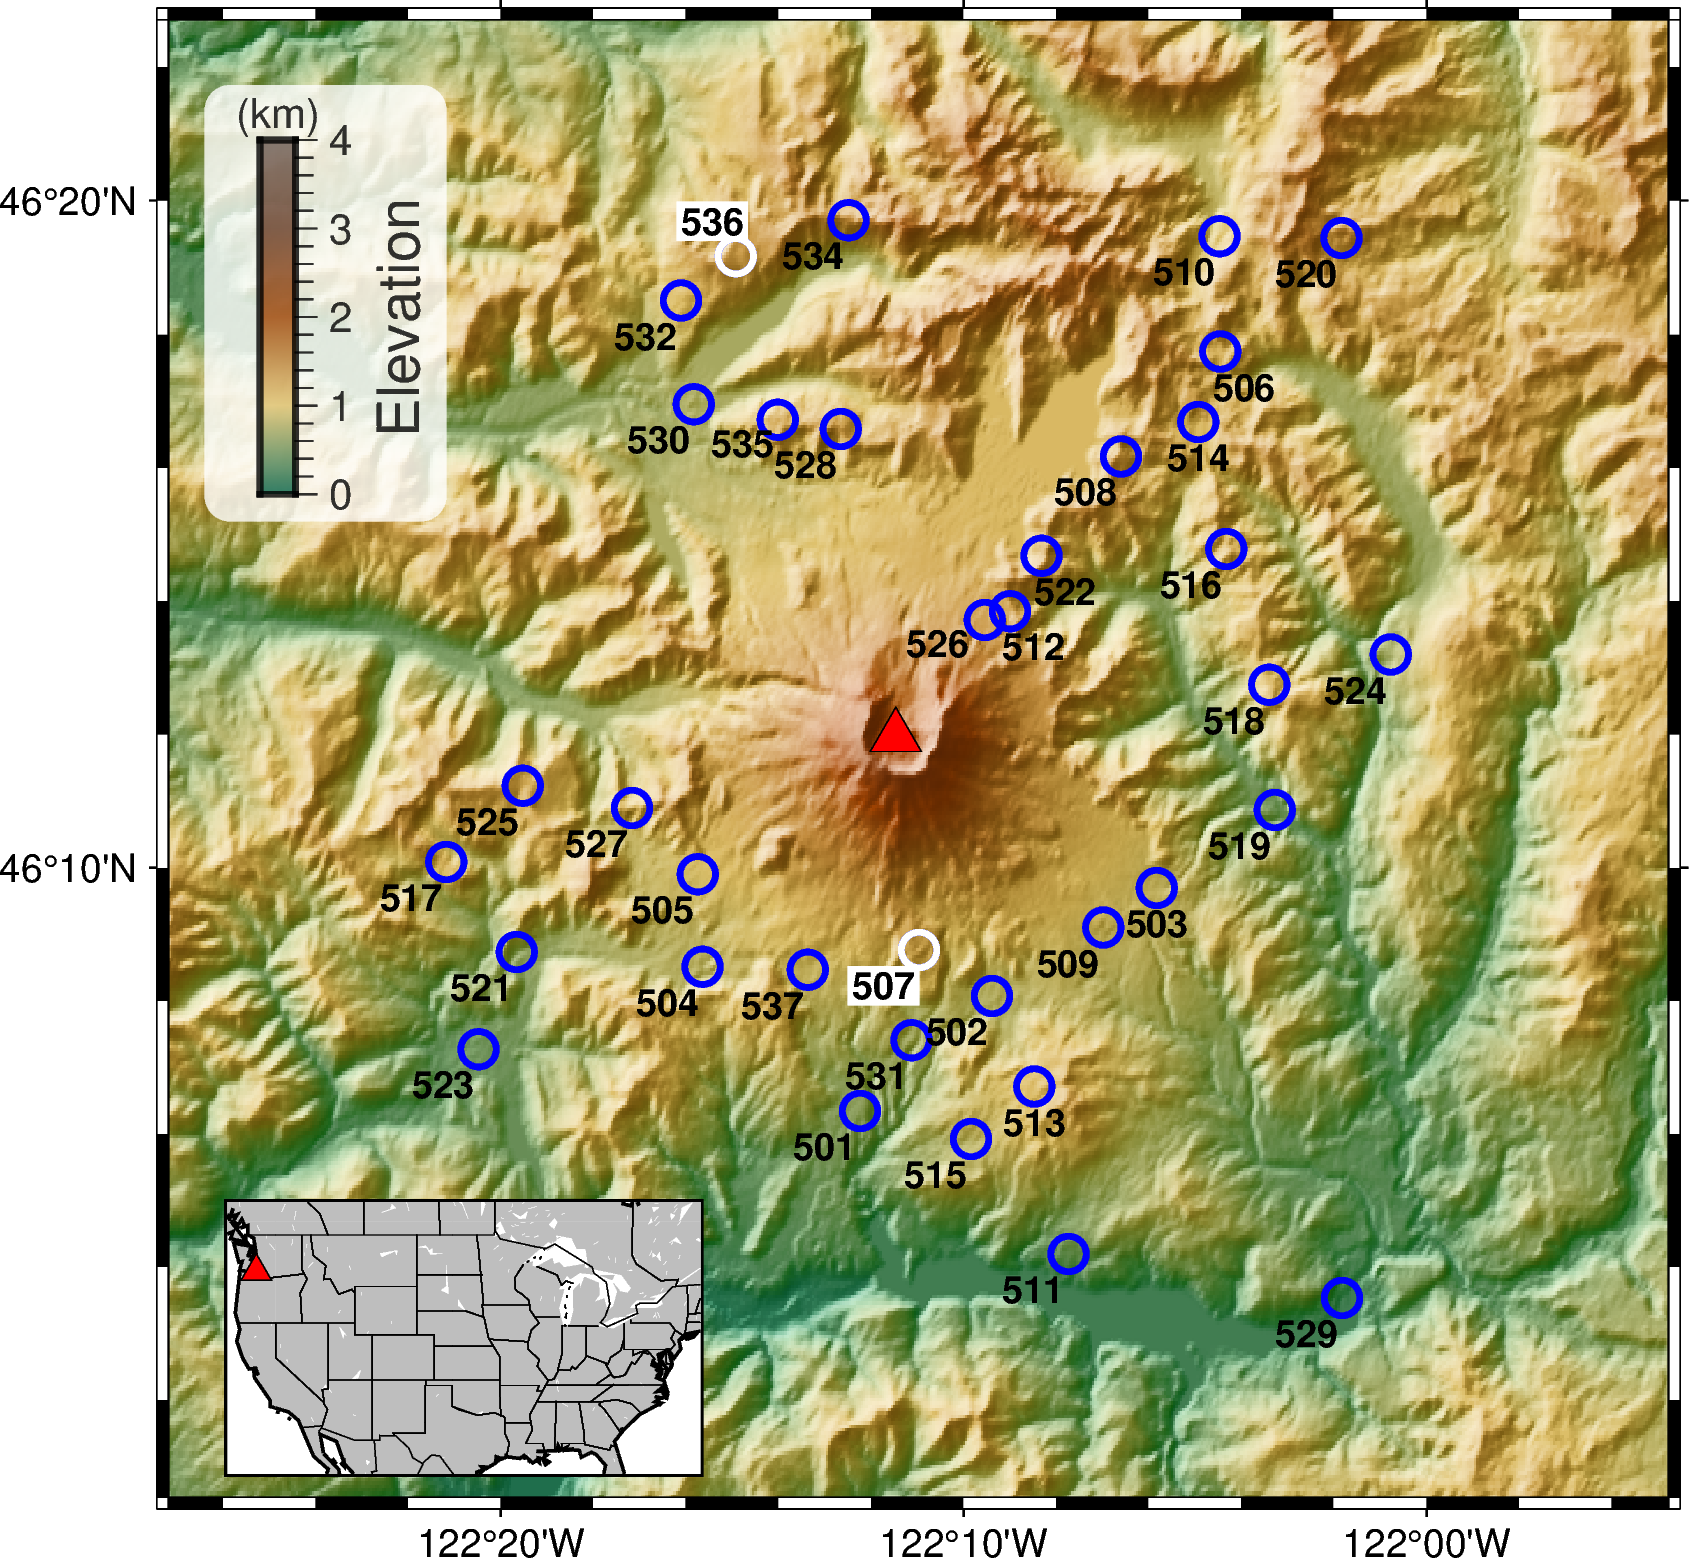

In [51]:
fig = __makeplot_eventmap(config, coords)

In [52]:
fig.savefig("./mt_st_helens_stationmap.png", dpi=400, transparent=True)